# Text Classification


## Tokenization

In [1]:
import regex as re

def split_chars(text):
    return re.findall(r".", text)

In [2]:
chars = split_chars("The quick brown fox jumped over the lazy dog.")
chars[:12]

['T', 'h', 'e', ' ', 'q', 'u', 'i', 'c', 'k', ' ', 'b', 'r']

In [3]:
def split_words(text):
    return re.findall(r"[\w]+|[.,!?;]", text)

In [4]:
split_words("The quick brown fox jumped over the dog.")

['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'dog', '.']

In [5]:
vocabulary = {
    "[UNK]": 0,
    "the": 1,
    "quick": 2,
    "brown": 3,
    "fox": 4,
    "jumped": 5,
    "over": 6,
    "dog": 7,
    ".": 8,
}
words = split_words("The quick brown fox jumped over the lazy dog.")
indices = [vocabulary.get(word, 0) for word in words]
print(indices)

[0, 2, 3, 4, 5, 6, 1, 0, 7, 8]


In [6]:
class CharTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r".", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [7]:
import collections

def compute_char_vocabulary(inputs, max_size):
    char_counts = collections.Counter()
    for x in inputs:
        x = x.lower()
        tokens = re.findall(r".", x)
        char_counts.update(tokens)
    vocabulary = ["[UNK]"]
    most_common = char_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))

In [8]:
class WordTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r"[\w]+|[.,!?;]", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [9]:
def compute_word_vocabulary(inputs, max_size):
    word_counts = collections.Counter()
    for x in inputs:
        x = x.lower()
        tokens = re.findall(r"[\w]+|[.,!?;]", x)
        word_counts.update(tokens)
    vocabulary = ["[UNK]"]
    most_common = word_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))

In [10]:
from tensorflow import keras

filename = keras.utils.get_file(
    origin="https://www.gutenberg.org/files/2701/old/moby10b.txt",
)
moby_dick = list(open(filename, "r"))

vocabulary = compute_char_vocabulary(moby_dick, max_size=100)
char_tokenizer = CharTokenizer(vocabulary)

1256167/1256167 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
print("Vocabulary length:", len(vocabulary))

print("Vocabulary start:", list(vocabulary.keys())[:10])

print("Vocabulary end:", list(vocabulary.keys())[-10:])

print("Line length:", len(char_tokenizer(
    "Call me Ishmael. Some years ago--never mind how long precisely."
)))

Vocabulary length: 64
Vocabulary start: ['[UNK]', ' ', 'e', 't', 'a', 'o', 'n', 'i', 's', 'h']
Vocabulary end: ['@', '$', '%', '#', '=', '~', '&', '+', '<', '>']
Line length: 63


In [12]:
vocabulary = compute_word_vocabulary(moby_dick, max_size=2_000)
word_tokenizer = WordTokenizer(vocabulary)

In [13]:
print("Vocabulary length:", len(vocabulary))
print("Vocabulary start:", list(vocabulary.keys())[:5])
print("Vocabulary end:", list(vocabulary.keys())[-5:])
print("Line length:", len(word_tokenizer(
    "Call me Ishmael. Some years ago--never mind how long precisely."
)))

Vocabulary length: 2000
Vocabulary start: ['[UNK]', ',', 'the', '.', 'of']
Vocabulary end: ['tambourine', 'subtle', 'perseus', 'elevated', 'repose']
Line length: 13


In [14]:
data = [
    "the quick brown fox",
    "the slow brown fox",
    "the quick brown foxhound",
]

In [15]:
def count_and_split_words(data):
    counts = collections.Counter()
    for line in data:
        line = line.lower()
        for word in re.findall(r"[\w]+|[.,!?;]", line):
            chars = re.findall(r".", word)
            split_word = " ".join(chars)
            counts[split_word] += 1
    return dict(counts)

counts = count_and_split_words(data)

In [16]:
counts

{'t h e': 3,
 'q u i c k': 2,
 'b r o w n': 3,
 'f o x': 2,
 's l o w': 1,
 'f o x h o u n d': 1}

In [17]:
def count_pairs(counts):
    pairs = collections.Counter()
    for word, freq in counts.items():
        symbols = word.split()
        for pair in zip(symbols[:-1], symbols[1:]):
            pairs[pair] += freq
    return pairs

def merge_pair(counts, first, second):
    split = re.compile(f"(?<!\S){first} {second}(?!\S)")
    merged = f"{first}{second}"
    return {split.sub(merged, word): count for word, count in counts.items()}

for i in range(10):
    pairs = count_pairs(counts)
    first, second = max(pairs, key=pairs.get)
    counts = merge_pair(counts, first, second)
    print(list(counts.keys()))

['t h e', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['th e', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'br ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brown', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brown', 'fo x', 's l ow', 'fo x h o u n d']
['the', 'q u i c k', 'brown', 'fox', 's l ow', 'fox h o u n d']
['the', 'qu i c k', 'brown', 'fox', 's l ow', 'fox h o u n d']
['the', 'qui c k', 'brown', 'fox', 's l ow', 'fox h o u n d']


In [18]:
def compute_sub_word_vocabulary(dataset, vocab_size):
    counts = count_and_split_words(dataset)

    char_counts = collections.Counter()
    for word in counts:
        for char in word.split():
            char_counts[char] += counts[word]
    most_common = char_counts.most_common()
    vocab = ["[UNK]"] + [char for char, freq in most_common]
    merges = []

    while len(vocab) < vocab_size:
        pairs = count_pairs(counts)
        if not pairs:
            break
        first, second = max(pairs, key=pairs.get)
        counts = merge_pair(counts, first, second)
        vocab.append(f"{first}{second}")
        merges.append(f"{first} {second}")

    vocab = dict((token, index) for index, token in enumerate(vocab))
    merges = dict((token, rank) for rank, token in enumerate(merges))
    return vocab, merges

In [19]:
class SubWordTokenizer:
    def __init__(self, vocabulary, merges):
        self.vocabulary = vocabulary
        self.merges = merges
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def bpe_merge(self, word):
        while True:
            pairs = re.findall(r"(?<!\S)\S+ \S+(?!\S)", word, overlapped=True)
            if not pairs:
                break
            best = min(pairs, key=lambda pair: self.merges.get(pair, 1e9))
            if best not in self.merges:
                break
            first, second = best.split()
            split = re.compile(f"(?<!\S){first} {second}(?!\S)")
            merged = f"{first}{second}"
            word = split.sub(merged, word)
        return word

    def split(self, inputs):
        tokens = []
        for word in re.findall(r"[\w]+|[.,!?;]", inputs):
            word = " ".join(re.findall(r".", word))
            word = self.bpe_merge(word)
            tokens.extend(word.split())
        return tokens

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [20]:
vocabulary, merges = compute_sub_word_vocabulary(moby_dick, 2_000)
sub_word_tokenizer = SubWordTokenizer(vocabulary, merges)

In [21]:
print("Vocabulary length:", len(vocabulary))
print("Vocabulary start:", list(vocabulary.keys())[:10])
print("Vocabulary end:", list(vocabulary.keys())[-7:])
print("Line length:", len(sub_word_tokenizer(
    "Call me Ishmael. Some years ago--never mind how long precisely."
)))

Vocabulary length: 2000
Vocabulary start: ['[UNK]', 'e', 't', 'a', 'o', 'n', 'i', 's', 'h', 'r']
Vocabulary end: ['bright', 'pilot', 'sco', 'ben', 'dem', 'gale', 'ilo']
Line length: 16


## IMDb Classification

In [33]:
import os, pathlib, shutil, random

zip_path = keras.utils.get_file(
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    fname="imdb",
    extract=True,
)

imdb_extract_dir = pathlib.Path(zip_path) / "aclImdb"

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [34]:
for path in imdb_extract_dir.glob("*/*"):
    if path.is_dir():
        print(path)

/root/.keras/datasets/imdb/aclImdb/train/neg
/root/.keras/datasets/imdb/aclImdb/train/pos
/root/.keras/datasets/imdb/aclImdb/train/unsup
/root/.keras/datasets/imdb/aclImdb/test/neg
/root/.keras/datasets/imdb/aclImdb/test/pos


In [35]:
print(open(imdb_extract_dir / "train" / "pos" / "4077_10.txt", "r").read())

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy


In [36]:
train_dir = pathlib.Path("imdb_train")
test_dir = pathlib.Path("imdb_test")
val_dir = pathlib.Path("imdb_val")

shutil.copytree(imdb_extract_dir / "test", test_dir)

val_percentage = 0.2
for category in ("neg", "pos"):
    src_dir = imdb_extract_dir / "train" / category
    src_files = os.listdir(src_dir)
    random.Random(1337).shuffle(src_files)
    num_val_samples = int(len(src_files) * val_percentage)

    os.makedirs(val_dir / category)
    for file in src_files[:num_val_samples]:
        shutil.copy(src_dir / file, val_dir / category / file)
    os.makedirs(train_dir / category)
    for file in src_files[num_val_samples:]:
        shutil.copy(src_dir / file, train_dir / category / file)

In [37]:
from tensorflow.keras.utils import text_dataset_from_directory

batch_size = 32
train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [38]:
from keras import layers

max_tokens = 20_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="multi_hot",
)
train_ds_no_labels = train_ds.map(lambda x, y: x)
text_vectorization.adapt(train_ds_no_labels)

bag_of_words_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [39]:
x, y = next(bag_of_words_train_ds.as_numpy_iterator())
x.shape
y.shape

(32,)

In [40]:
def build_linear_classifier(max_tokens, name):
    inputs = keras.Input(shape=(max_tokens,))
    outputs = layers.Dense(1, activation="sigmoid")(inputs)
    model = keras.Model(inputs, outputs, name=name)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_linear_classifier(max_tokens, "bag_of_words_classifier")

In [41]:
model.summary(line_length=80)

Model: "bag_of_words_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)          │ (None, 20000)            │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense (Dense)                     │ (None, 1)                │        20,001 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 20,001 (78.13 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    patience=2,
)
history = model.fit(
    bag_of_words_train_ds,
    validation_data=bag_of_words_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7756 - loss: 0.5471 - val_accuracy: 0.8776 - val_loss: 0.3561
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9003 - loss: 0.3126 - val_accuracy: 0.8910 - val_loss: 0.3016
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9233 - loss: 0.2476 - val_accuracy: 0.8944 - val_loss: 0.2798
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9387 - loss: 0.2093 - val_accuracy: 0.8974 - val_loss: 0.2687
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9479 - loss: 0.1832 - val_accuracy: 0.8964 - val_loss: 0.2625
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9554 - loss: 0.1631 - val_accuracy: 0.8978 - val_loss: 0.2597
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9630 - loss: 0.1460 - val_accuracy: 0.8988 - val_loss: 0.2589
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9684 - loss: 0.1313 - val_accuracy: 0.

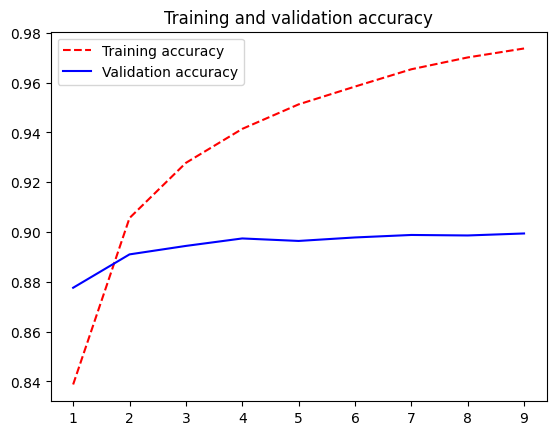

In [43]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [44]:
test_loss, test_acc = model.evaluate(bag_of_words_test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8864 - loss: 0.2834


In [45]:
test_loss

0.28238463401794434

In [46]:
test_acc

0.8862400054931641

In [47]:
max_tokens = 30_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="multi_hot",
    ngrams=2,
)

text_vectorization.adapt(train_ds_no_labels)

bigram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

bigram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

bigram_test_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [48]:
x, y = next(bigram_train_ds.as_numpy_iterator())

In [49]:
x.shape

(32, 30000)

In [50]:
text_vectorization.get_vocabulary()[100:108]

[np.str_('in a'),
 np.str_('most'),
 np.str_('him'),
 np.str_('dont'),
 np.str_('it was'),
 np.str_('one of'),
 np.str_('made'),
 np.str_('for the')]

In [51]:
model = build_linear_classifier(max_tokens, "bigram_classifier")
model.fit(
    bigram_train_ds,
    validation_data=bigram_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8102 - loss: 0.4930 - val_accuracy: 0.8980 - val_loss: 0.2981
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9328 - loss: 0.2387 - val_accuracy: 0.9020 - val_loss: 0.2605
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9569 - loss: 0.1740 - val_accuracy: 0.9044 - val_loss: 0.2469
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9723 - loss: 0.1343 - val_accuracy: 0.9066 - val_loss: 0.2408
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9829 - loss: 0.1065 - val_accuracy: 0.9060 - val_loss: 0.2391
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9887 - loss: 0.0864 - val_accuracy: 0.9060 - val_loss: 0.2406
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9931 - loss: 0.0704 - val_accuracy: 0.9052 - val_loss: 0.2432


In [52]:
test_loss, test_acc = model.evaluate(bigram_test_ds)
test_acc

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9065 - loss: 0.2406


0.906000018119812

In [53]:
max_length = 600
max_tokens = 30_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(train_ds_no_labels)

In [54]:
sequence_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

sequence_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

sequence_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [55]:
x, y = next(sequence_test_ds.as_numpy_iterator())

In [56]:
x.shape

(32, 600)

In [57]:
x

array([[  657,  8360, 11078, ...,     0,     0,     0],
       [   10,   320,     2, ...,     0,     0,     0],
       [ 1210,     1,     9, ...,     0,     0,     0],
       ...,
       [   10,  2309,     2, ...,     0,     0,     0],
       [   45,    10,    67, ...,     0,     0,     0],
       [   10,  1383,    45, ...,     0,     0,     0]])

In [58]:
import numpy as np
from tensorflow import keras
from keras import ops, layers

class OneHotEncoding(layers.Layer):
    def __init__(self, depth, **kwargs):
        super().__init__(**kwargs)
        self.depth = depth

    def call(self, inputs):
        flat_inputs = ops.reshape(ops.cast(inputs, "int"), [-1])
        one_hot_vectors = ops.eye(self.depth)
        outputs = ops.take(one_hot_vectors, flat_inputs, axis=0)
        return ops.reshape(outputs, ops.shape(inputs) + (self.depth,))


In [59]:
one_hot_encoding = OneHotEncoding(max_tokens)

In [60]:
x, y = next(sequence_train_ds.as_numpy_iterator())
one_hot_encoding(x).shape

TensorShape([32, 600, 30000])

In [61]:
hidden_dim = 64
inputs = keras.Input(shape=(max_length,), dtype="int32")
x = one_hot_encoding(inputs)
x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
x = layers.Dropout(0.5)(x)
ouputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, ouputs, name="lstm_with_one_hot")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [62]:
model.summary(line_length=80)

Model: "lstm_with_one_hot"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)        │ (None, 600)              │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ one_hot_encoding (OneHotEncoding) │ (None, 600, 30000)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)     │ (None, 128)              │    15,393,280 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout (Dropout)                 │ (None, 128)              │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_2 (Dense)                   │ (None, 1)                │           129 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 15,393,409 (58.72 MB)

 Trainable params: 15,393,409 (58.72 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
model.fit(
    sequence_test_ds,
    validation_data=sequence_train_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 120s 147ms/step - accuracy: 0.6540 - loss: 0.6225 - val_accuracy: 0.8107 - val_loss: 0.4893
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 115s 147ms/step - accuracy: 0.8069 - loss: 0.4584 - val_accuracy: 0.5522 - val_loss: 0.6887
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 115s 147ms/step - accuracy: 0.5505 - loss: 0.6998 - val_accuracy: 0.6180 - val_loss: 0.6694


In [63]:
test_loss, test_acc = model.evaluate(sequence_test_ds)

In [64]:
test_acc

0.906000018119812

In [65]:
hidden_dim = 64
inputs = keras.Input(shape=(max_length,), dtype="int32")
x = keras.layers.Embedding(
    input_dim=max_tokens,
    output_dim=hidden_dim,
    mask_zero=True,
)(inputs)
x = one_hot_encoding(inputs)
x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
x = layers.Dropout(0.5)(x)
ouputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, ouputs, name="lstm_with_one_hot")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [66]:
model.summary(line_length=80)

Model: "lstm_with_one_hot"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)        │ (None, 600)              │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ one_hot_encoding (OneHotEncoding) │ (None, 600, 30000)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional)   │ (None, 128)              │    15,393,280 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout_1 (Dropout)               │ (None, 128)              │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_3 (Dense)                   │ (None, 1)                │           129 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 15,393,409 (58.72 MB)

 Trainable params: 15,393,409 (58.72 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.fit(
    sequence_test_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 91s 114ms/step - accuracy: 0.6671 - loss: 0.5999 - val_accuracy: 0.7048 - val_loss: 0.5936
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 88s 113ms/step - accuracy: 0.8096 - loss: 0.4524 - val_accuracy: 0.8246 - val_loss: 0.4284
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 88s 113ms/step - accuracy: 0.8953 - loss: 0.2851 - val_accuracy: 0.8632 - val_loss: 0.3468
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 89s 113ms/step - accuracy: 0.9398 - loss: 0.1727 - val_accuracy: 0.8420 - val_loss: 0.3927
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 89s 113ms/step - accuracy: 0.9591 - loss: 0.1251 - val_accuracy: 0.8466 - val_loss: 0.6226


In [68]:
test_loss, test_acc = model.evaluate(sequence_test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.9450 - loss: 0.1517


In [69]:
test_acc

0.9542800188064575

In [70]:
imdb_vocabulary = text_vectorization.get_vocabulary()
tokenize_no_padding = keras.layers.TextVectorization(
    vocabulary=imdb_vocabulary,
    split="whitespace",
    output_mode="int",
)

In [77]:
import tensorflow as tf

context_size = 4
window_size = 9

def window_data(token_ids):
    num_windows = tf.maximum(tf.size(token_ids) - context_size * 2, 0)
    windows = tf.range(window_size)[None, :]
    windows = windows + tf.range(num_windows)[:, None]
    windowed_tokens = tf.gather(token_ids, windows)
    return tf.data.Dataset.from_tensor_slices(windowed_tokens)

def split_label(window):
    left = window[:context_size]
    right = window[context_size + 1 :]
    bag = tf.concat((left, right), axis=0)
    label = window[4]
    return bag, label

dataset = keras.utils.text_dataset_from_directory(
    imdb_extract_dir / "train", batch_size=None
)
dataset = dataset.map(lambda x, y: x, num_parallel_calls=8)
dataset = dataset.map(tokenize_no_padding, num_parallel_calls=8)
dataset = dataset.interleave(window_data, cycle_length=8, num_parallel_calls=8)
dataset = dataset.map(split_label, num_parallel_calls=8)

Found 75000 files belonging to 3 classes.


In [78]:
hidden_dim = 64
inputs = keras.Input(shape=(context_size * 2,))
cbow_embedding = layers.Embedding(
    max_tokens,
    hidden_dim,
)
x = cbow_embedding(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(max_tokens, activation="sigmoid")(x)
chow_model = keras.Model(inputs, outputs, name="cbow")
chow_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [79]:
chow_model.summary(line_length=80)

Model: "cbow"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)        │ (None, 8)                │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ embedding_2 (Embedding)           │ (None, 8, 64)            │     1,920,000 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ global_average_pooling1d_1        │ (None, 64)               │             0 │
│ (GlobalAveragePooling1D)          │                          │               │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_5 (Dense)                   │ (None, 30000)            │     1,950,000 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 3,870,000 (14.76 MB)

 Trainable params: 3,870,000 (14.76 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
dataset = dataset.batch(1024).cache()
chow_model.fit(dataset, epochs=4)

Epoch 1/4
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 280s 17ms/step - loss: 6.6729 - sparse_categorical_accuracy: 0.0831
Epoch 2/4
   57/16503 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 5.9889 - sparse_categorical_accuracy: 0.1259

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


16503/16503 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 5.9373 - sparse_categorical_accuracy: 0.1259
Epoch 3/4
   58/16503 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 5.7905 - sparse_categorical_accuracy: 0.1343

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


16503/16503 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 5.7649 - sparse_categorical_accuracy: 0.1343
Epoch 4/4
   57/16503 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 5.7050 - sparse_categorical_accuracy: 0.1377

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


16503/16503 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 5.6850 - sparse_categorical_accuracy: 0.1371


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [81]:
inputs = keras.Input(shape=(max_length,))
lstm_embedding = layers.Embedding(
    input_dim=max_tokens,
    output_dim=hidden_dim,
    mask_zero=True,
)
x = lstm_embedding(inputs)
x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="lstm_with_cbow")

In [82]:
lstm_embedding.embeddings.assign(cbow_embedding.embeddings)

<Variable path=embedding_2/embeddings, shape=(30000, 64), dtype=float32, value=[[-0.00407781 -0.03429322 -0.0354957  ...  0.04965753  0.03685502
   0.04322615]
 [-0.04465905 -0.39187458 -0.21119696 ... -0.1947596   0.0580229
  -0.13641337]
 [ 0.18355815 -0.33266878  0.08350961 ... -0.5901875   0.44663066
   0.22241126]
 ...
 [ 0.05529613 -0.11337483 -0.2659838  ...  0.01814229  0.1793608
  -0.10779848]
 [ 0.05823801  0.2701728   0.17243694 ...  0.02227223  0.12707739
  -0.76850325]
 [-0.04277628 -0.31164765 -0.0542133  ... -0.03772752  0.01586862
   0.09262299]]>

In [83]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [84]:
model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.7215 - loss: 0.5285 - val_accuracy: 0.8286 - val_loss: 0.3830
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.8633 - loss: 0.3326 - val_accuracy: 0.8742 - val_loss: 0.3114
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.8752 - loss: 0.3021 - val_accuracy: 0.8596 - val_loss: 0.3381
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.9044 - loss: 0.2350 - val_accuracy: 0.8826 - val_loss: 0.3147


In [85]:
test_loss, test_acc = model.evaluate(sequence_test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8688 - loss: 0.3138


In [86]:
test_acc

0.8698800206184387